# Projet Text Mining

## Sujet 1. Qualité des document embeddings

Membres : Mohamed BEN HAMDOUNE | Louis BOURQUARD | Lucas ISCOVICI

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import *
from sklearn.decomposition import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import *
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import *
from sklearn.cluster import MiniBatchKMeans
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm,tqdm_pandas,tqdm_notebook
import os
from progress.bar import Bar
from ipywidgets import FloatProgress
import time
import os
from sklearn.cluster import KMeans
from tqdm import tqdm,tqdm_pandas,tqdm_notebook
tqdm.pandas(desc="progress-bar")
from sklearn.decomposition import NMF
from collections import Counter
from sklearn import preprocessing
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk import word_tokenize 
import nltk
import multiprocessing
import scikitplot as skplt
from mpl_toolkits.mplot3d import Axes3D
from spherecluster import SphericalKMeans
from sklearn.feature_extraction import text 
#from word_cloud.word_cloud_generator import WordCloud 
#from IPython.core.display import HTML
import pandas as pd

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MOBENHAMDOUNE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
pathDonnees="donnees/"

In [4]:
readTable = lambda filename,sep="\n": pd.read_table(pathDonnees+"/"+filename,delimiter=sep,header=None,decimal=".")

In [5]:
def get_top_n_words(bag_of_words,vec, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    """
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [182]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc[1], model.infer_vector(doc[0], steps=20, alpha=0.025)) for doc in sents])
    return targets, regressors

In [41]:
def acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [42]:
def scoring_cluster(methode,encoded_label,y_pred):
    ari = adjusted_rand_score(encoded_label,y_pred)
    nmi = normalized_mutual_info_score(encoded_label,y_pred,average_method='arithmetic')
    accuracy = acc(encoded_label,y_pred)
    print("ARI:",round(ari*100,4),"NMI:",round(nmi*100,4),"Accuracy:",round(accuracy*100,4))

In [325]:
def analyse(methode,preproc,true_label,nb_clusters=3,normalizer=True,scikit=True):        
        if scikit:
            data = methode.fit_transform(preproc)
        else:
            data = preproc
        if normalizer:
            data = Normalizer(norm='l2',copy=False).fit_transform(data)
        skplt.cluster.plot_elbow_curve(SphericalKMeans(random_state=42,n_jobs=-1),data,title = "Elbow Curve avec Spherical K-means" ,cluster_ranges=range(1, 15))
        skplt.cluster.plot_elbow_curve(KMeans(random_state=42,n_jobs=-1,precompute_distances=True),data,title="Elbow Curve avec K-means" ,cluster_ranges=range(1, 15))
        ("Fitting For Spherical K-means for ",nb_clusters,"...")
        skmeans = SphericalKMeans(n_clusters=nb_clusters,random_state=42,n_jobs=-1).fit(data)
        ("Fitting For Spherical K-means for ",nb_clusters,"...")
        kmeans = KMeans(n_clusters=nb_clusters,random_state=42,n_jobs=-1,precompute_distances=True).fit(data)
        y_pred_skmeans = skmeans.predict(data)
        y_pred_kmeans = kmeans.predict(data)
        print("Results from Spherical K-means")
        scoring_cluster(skmeans,true_label,y_pred_skmeans)
        print("Results from K-means")
        scoring_cluster(kmeans,true_label,y_pred_kmeans)
        return methode,skmeans,kmeans,data

In [44]:
classic_raw=readTable("classic3_raw.txt")
classic_label=readTable("classic3_labels.txt")
classic_doc_50_dims = readTable("classic3_doc_50_dims.txt")
reuters_raw = readTable("reuters8_raw.txt")
reuers_labels = readTable("reuters8_labels.txt")
reuters_embeddings = np.loadtxt("./donnees/reuters8_embeddings.txt")
classic_embeddings_200 = np.loadtxt("./donnees/classic3_doc_200.txt")
classic_embeddings_25 = np.loadtxt("./donnees/classic3_doc_25_dims.txt")
classic_embeddings_50 = np.loadtxt("./donnees/classic3_doc_50_dims.txt")
classic_embeddings_150 = np.loadtxt("./donnees/classic3_doc_150_dims.txt")

#### CountVectorizer et TD-IDF

In [45]:
my_additional_stop_words = ['said']
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [46]:
vectorizer = CountVectorizer(stop_words = stop_words )
tf_idf = TfidfVectorizer(stop_words = stop_words )

### Analyse sur Reuers 8

In [47]:
reuers_labelU = np.unique(reuers_labels.values)
reuers_labelU

array(['acq', 'crude', 'earn', 'grain', 'interest', 'money-fx', 'ship',
       'trade'], dtype=object)

In [48]:
len(reuters_raw.values)

5485

In [49]:
X_countVectorizer_Reuers8 = vectorizer.fit_transform(reuters_raw.iloc[:,0])

In [50]:
X_tfidf_Reuers8 = tf_idf.fit_transform(reuters_raw.iloc[:,0])

In [17]:
X_countVectorizer_Reuers8.shape

(5485, 19758)

In [18]:
non_zero = np.count_nonzero(X_countVectorizer_Reuers8.toarray())
total_val = np.product(X_countVectorizer_Reuers8.shape)
sparsity = (total_val - non_zero) / total_val

In [19]:
print("La matrice est sparse à ",round(sparsity*100.,4),"%")

La matrice est sparse à  99.7943 %


In [20]:
list_num_word = get_top_n_words(X_tfidf_Reuers8,tf_idf,20)

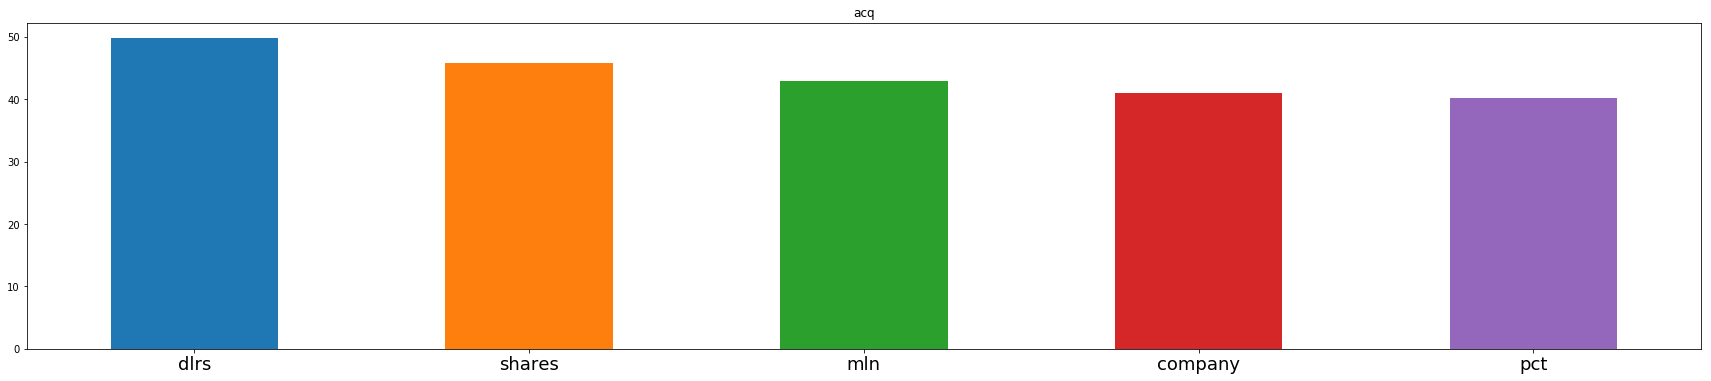

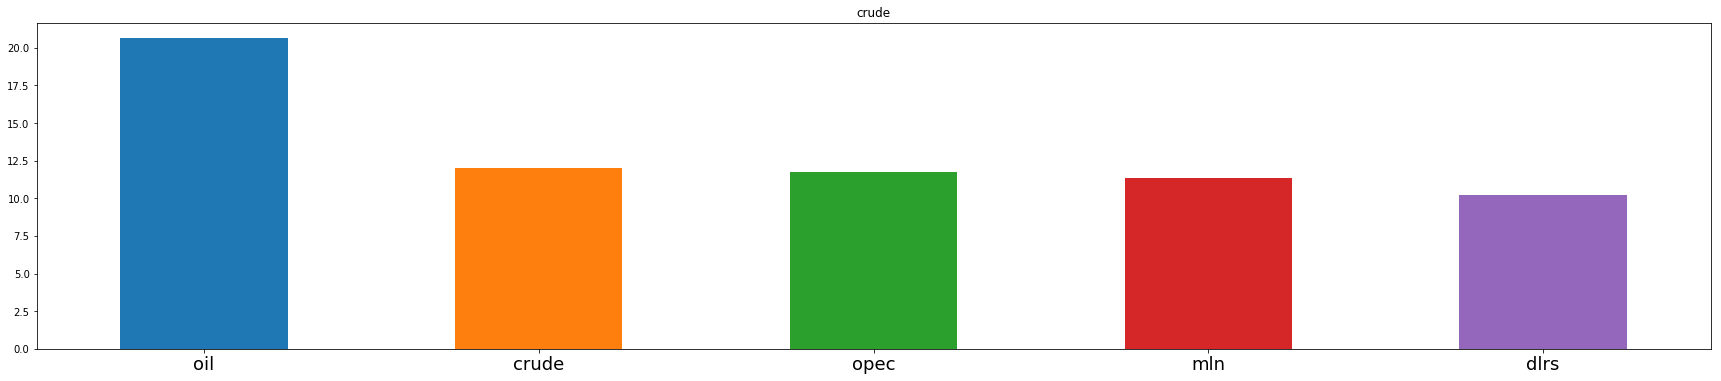

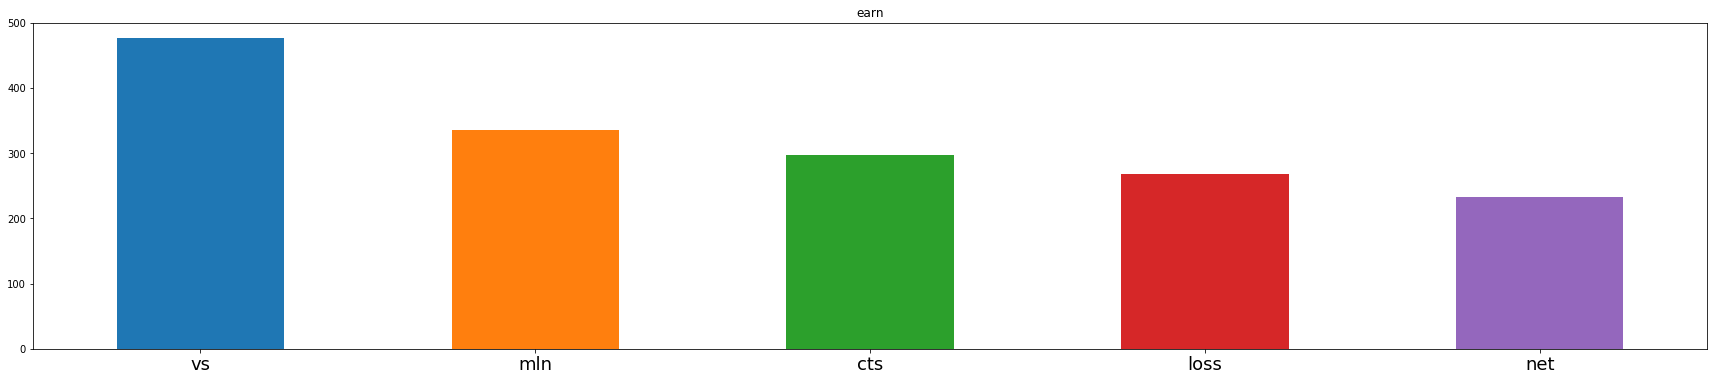

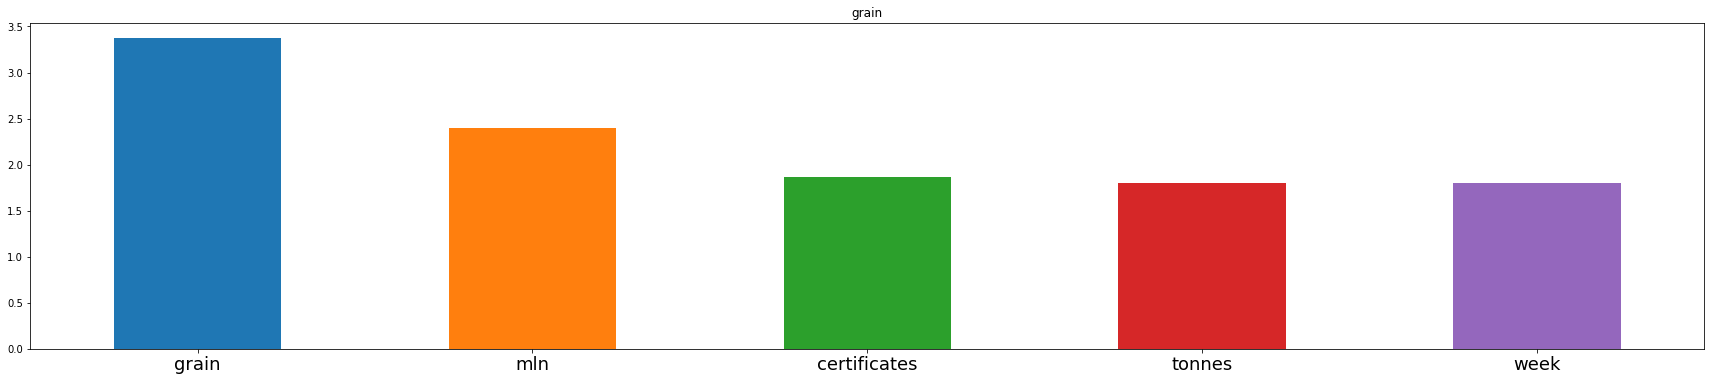

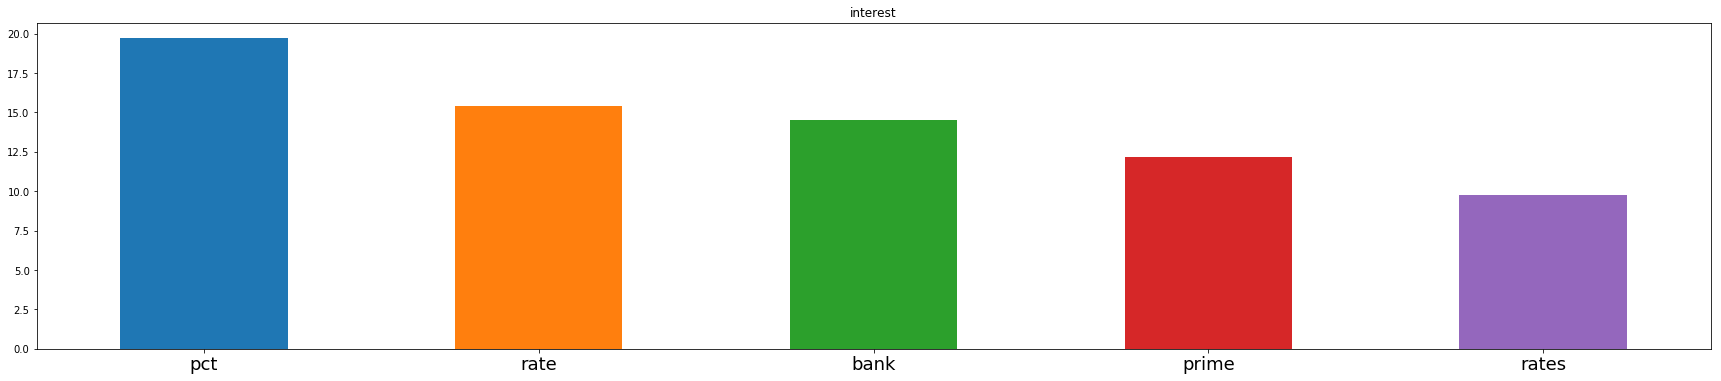

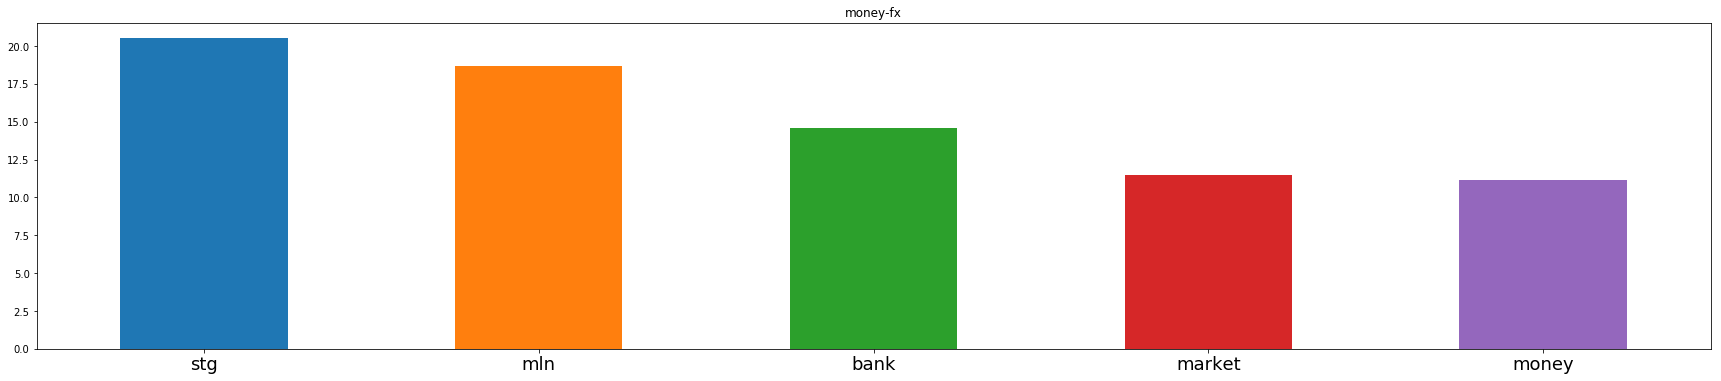

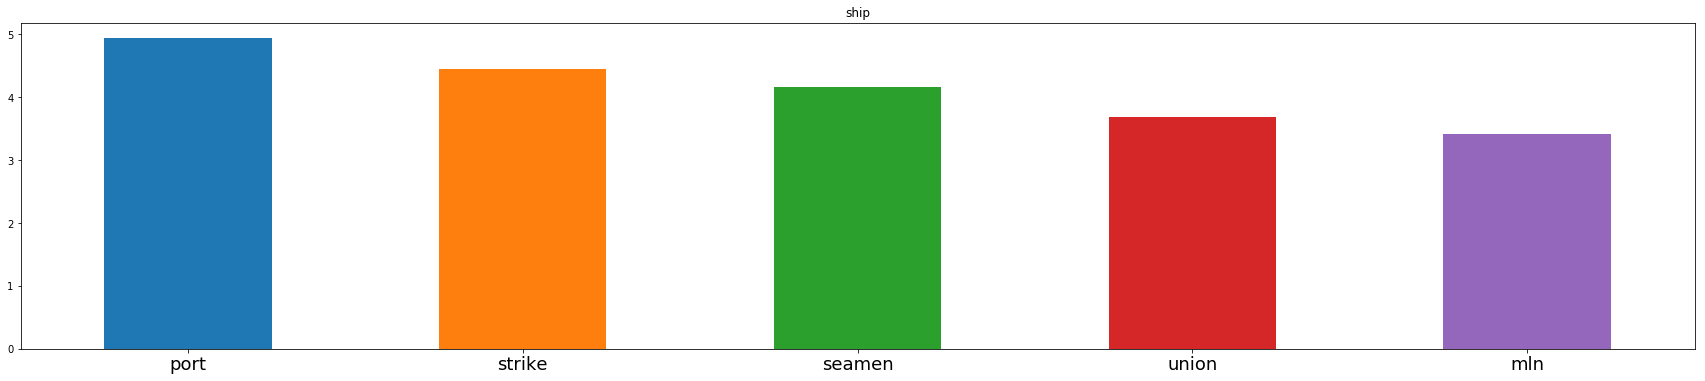

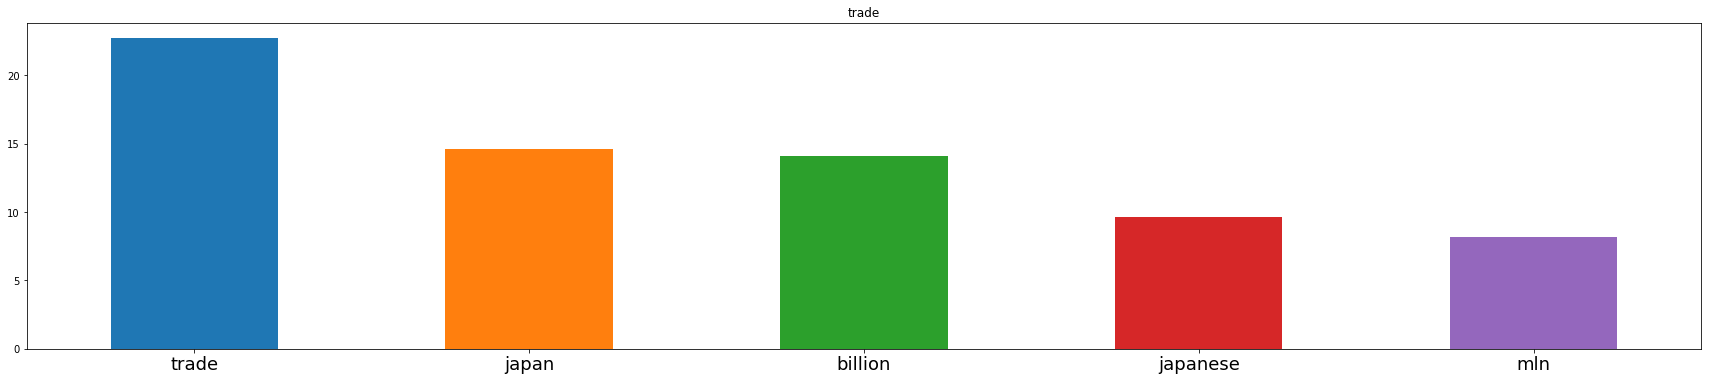

In [22]:
for i in range(8):    
    X = tf_idf.fit_transform(reuters_raw[reuers_labels==reuers_labelU[i]].dropna().iloc[:,0])
    list_num_word = get_top_n_words(X,tf_idf,5)
    x,y = zip(*list_num_word)
    plt.figure(figsize=(30, 6))
    plt.title(reuers_labelU[i])
    pd.Series(y,index=x).plot.bar()
    plt.xticks(rotation=0,size=18)
plt.show()

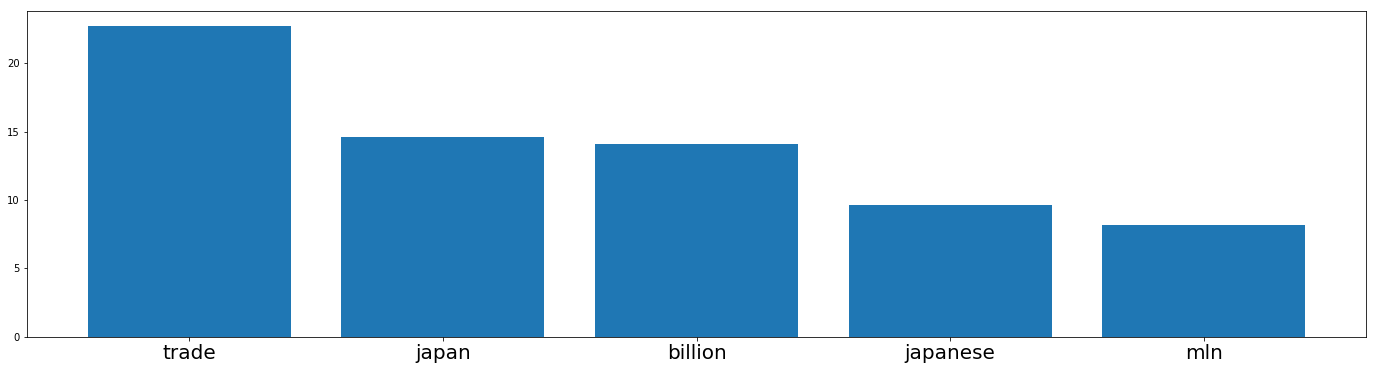

In [23]:
x,y = zip(*list_num_word)
plt.figure(figsize=(24, 6))
plt.bar(x,y)
plt.xticks(range(len(x)),x)
plt.xticks(rotation=0,size=20)
plt.show()

[('earn', 51.77757520510483), ('acq', 29.097538742023698), ('trade', 4.576116681859617), ('ship', 1.9690063810391976), ('grain', 0.7474931631722881), ('crude', 4.612579762989973), ('interest', 3.4639927073837744), ('money-fx', 3.7556973564266185)]


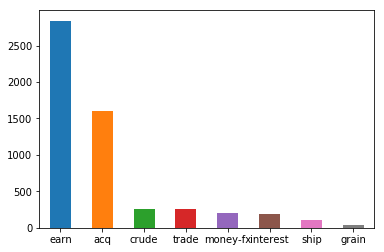

In [24]:
val_perc = Counter(list(reuers_labels.values.ravel()))
x_lab = [(i, val_perc[i] / len(reuers_labels.values.ravel()) * 100.0) for i in val_perc]
pd.Series(Counter(list(reuers_labels.values.ravel()))).sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=0)
print(x_lab)

### Analyse sur Classic3

Les noms de classes disponible.

In [25]:
classic_labelUC = np.unique(classic_label.values)
classic_labelUC

array(['cisi', 'cran', 'med'], dtype=object)

On dénombre 3891 lignes dans le document brut.

In [26]:
len(classic_raw.values)

3891

In [27]:
X_countVectorizer_Classic3 = vectorizer.fit_transform(classic_raw.iloc[:,0])

In [28]:
X_tfidf_Classic3 = tf_idf.fit_transform(classic_raw.iloc[:,0])

CountVectorizer représentant sur les lignes un document et en colonnes chaque mot  

In [29]:
X_tfidf_Classic3.shape

(3891, 21468)

In [30]:
non_zero = np.count_nonzero(X_tfidf_Classic3.toarray())
total_val = np.product(X_tfidf_Classic3.shape)
sparsity = (total_val - non_zero) / total_val

In [31]:
print("La matrice est sparse à ",round(sparsity*100.,4),"%")

La matrice est sparse à  99.7325 %


In [32]:
list_num_word_classic = get_top_n_words(X_tfidf_Classic3,tf_idf,5)

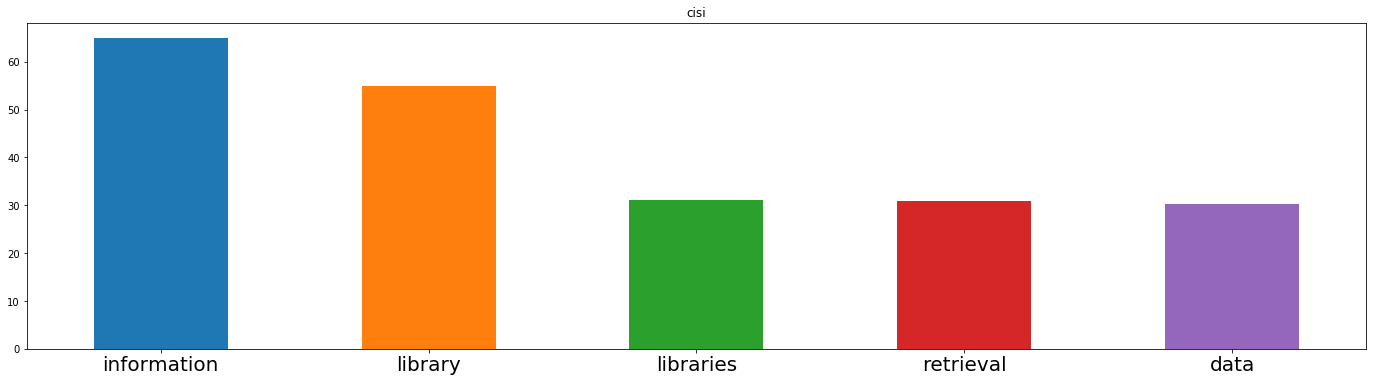

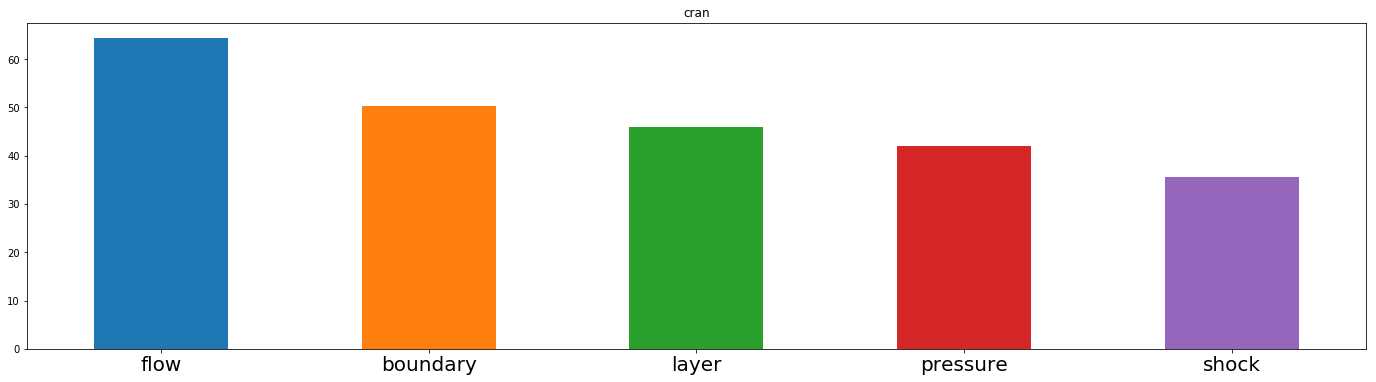

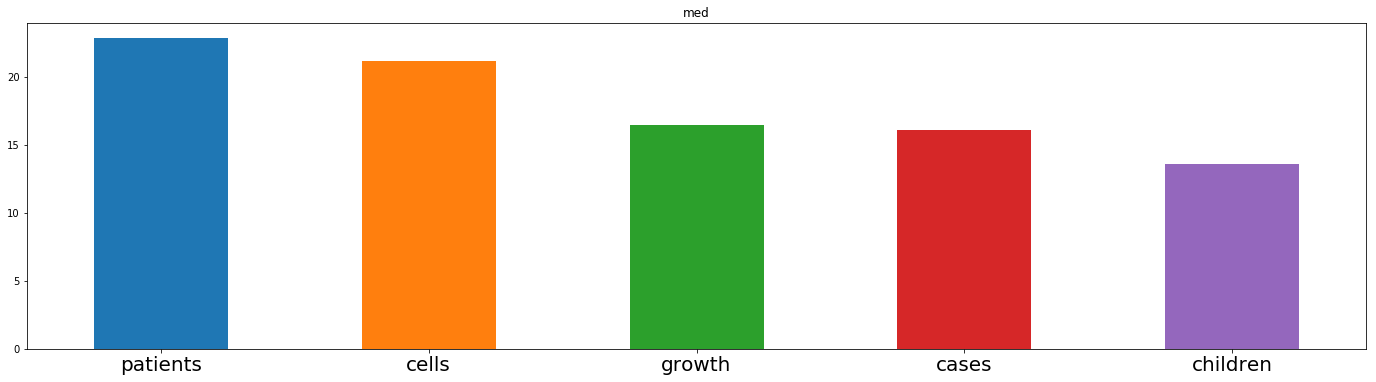

In [33]:
for i in range(3):    
    X = tf_idf.fit_transform(classic_raw[classic_label==classic_labelUC[i]].dropna().iloc[:,0])
    list_num_word = get_top_n_words(X,tf_idf,5)
    x,y = zip(*list_num_word)
    plt.figure(figsize=(24, 6))
    plt.title(classic_labelUC[i])
    pd.Series(y,index=x).plot.bar()
    plt.xticks(rotation=0,size=20)

plt.show()

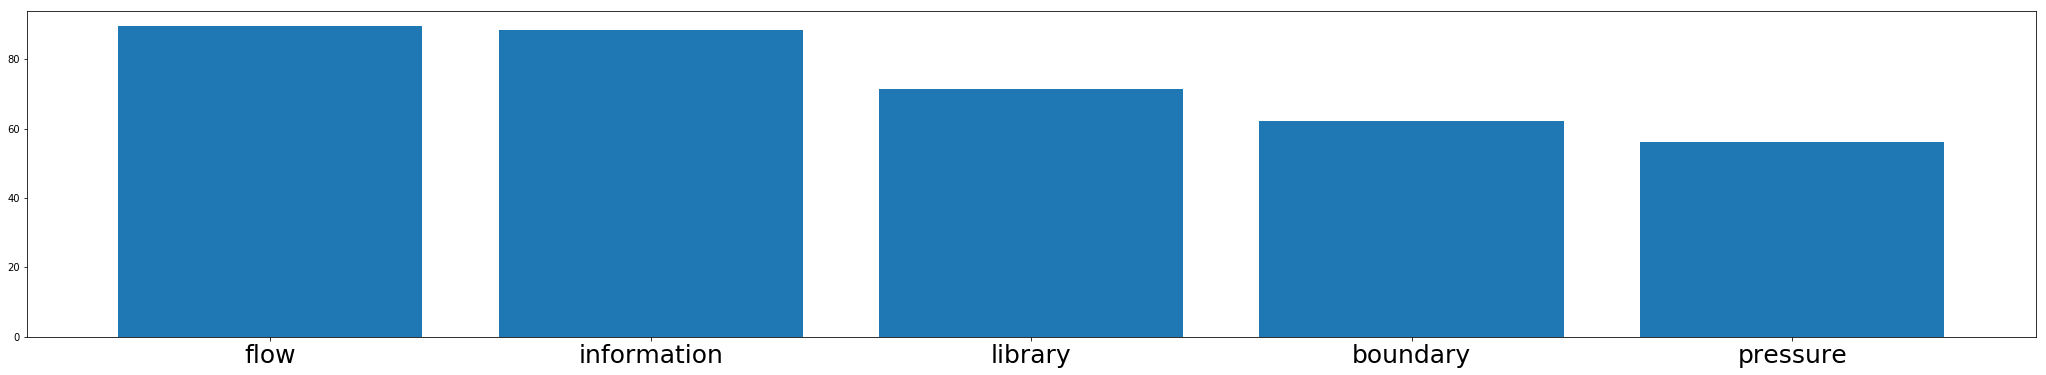

In [34]:
x,y = zip(*list_num_word_classic)
plt.figure(figsize=(36, 6))
plt.bar(x,y)
plt.xticks(size=25)
plt.show()

[('cisi', 37.5224877923413), ('cran', 35.92906707787201), ('med', 26.548445129786685)]


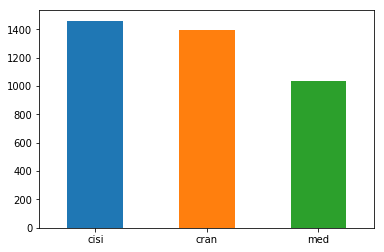

In [35]:
val_perc = Counter(list(classic_label.values.ravel()))
x_lab = [(i, val_perc[i] / len(classic_label.values.ravel()) * 100.0) for i in val_perc]
pd.Series(Counter(list(classic_label.values.ravel()))).plot(kind='bar')
plt.xticks(rotation=0)
print(x_lab)

### Encodage des labels sur Classic3 et Reurs8

In [36]:
le = preprocessing.LabelEncoder()
#### Encodage sur le jeux de données classic3
encoded_label_classic = le.fit_transform(classic_label.values.ravel())
label_encoded_classic = le.inverse_transform(encoded_label_classic)
#### Encodage sur le jeux de données Reuers
encoded_label_reuers = le.fit_transform(reuers_labels.values.ravel())
label_encoded_reuers = le.inverse_transform(encoded_label_reuers)

In [37]:
skmeans = SphericalKMeans(random_state=0)
kmeans = KMeans(random_state=0)

In [37]:
#wc=WordCloud(use_tfidf=False,stopwords=ENGLISH_STOP_WORDS)

In [38]:
# World Cloud sur Classic Raw
#embed_code=wc.get_embed_code(text=classic_raw[0].values,random_color=True,topn=100)
#HTML(embed_code)

In [39]:
# World Cloud sur Reuters Raw
#embed_code=wc.get_embed_code(text=reuters_raw[0].values,random_color=True,topn=100)
#HTML(embed_code)

#### Analyse sur la matrice embeddings Classic3 en utilisant K-means et Spherical K-means

Results from Spherical K-means
ARI: 4.0903 NMI: 3.6636 Accuracy: 43.4593
Results from K-means
ARI: 4.714 NMI: 4.0323 Accuracy: 42.971


(None,
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[ 0.3786785 ,  0.02512847, -0.08904288, ..., -0.02762856,
          0.59839666, -0.07439869],
        [ 0.80238432,  0.19851074, -0.1580485 , ...,  0.92053527,
          1.09399891,  0.58302647],
        [-0.01408605, -0.90978378, -0.05489326, ...,  1.18369818,
          0.5359115 , -0.10988763],
        ...,
        [ 0.54865235,  0.36398473, -0.35963228, ...,  0.63622916,
          0.44659382,  0.17618425],
        [ 0.44769338,  0.49418932, -0.4116697 , ..., -0.63800782,
          0.67122918,  0.26368022],
        [ 0.22110216, -0.15777981, -0.51302952, ...,  0.25679827,
          0.16811675,  0.13721225]]))

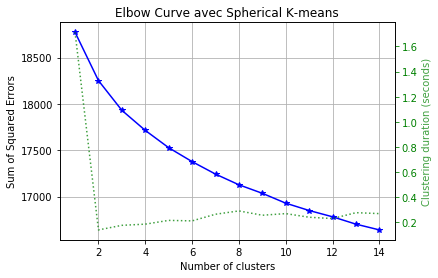

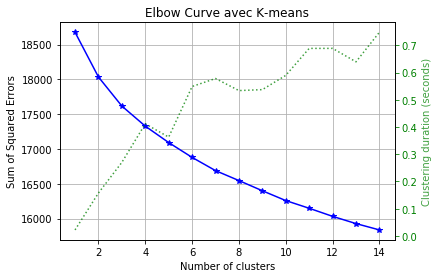

In [40]:
# Matrice embeddings de taille 25
analyse(methode=None,preproc=classic_embeddings_25,true_label=encoded_label_classic,nb_clusters=3,scikit=False,normalizer=False)

Results from Spherical K-means
ARI: 12.6315 NMI: 10.5755 Accuracy: 56.8234
Results from K-means
ARI: 11.3134 NMI: 10.1724 Accuracy: 54.3819


(None,
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[-0.10287954, -0.15520956, -0.22859384, ..., -0.50745475,
         -0.00710398,  0.19848874],
        [-0.1496999 ,  0.05993332, -0.13102919, ..., -0.33112043,
         -0.35566404,  0.37882116],
        [-0.35714632, -0.29198709,  0.35281712, ...,  0.20181423,
         -0.52168304,  0.46821606],
        ...,
        [-0.22347155, -0.01221187, -0.00252338, ...,  0.08894707,
         -0.29475415,  0.04236425],
        [ 0.6248064 ,  0.11888157,  0.39070663, ..., -0.2563763 ,
         -0.12574099, -0.34691817],
        [-0.43539441, -0.09174893,  0.11854145, ...,  0.06522676,
         -0.25483006,  0.25448623]]))

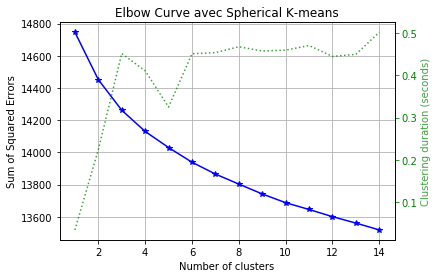

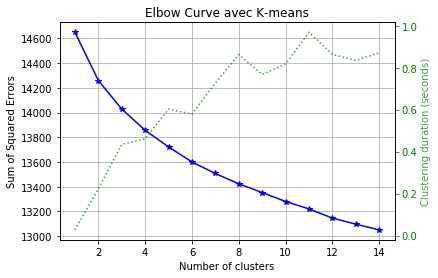

In [41]:
# Matrice embeddings de taille 50
analyse(methode=None,preproc=classic_embeddings_50,true_label=encoded_label_classic,nb_clusters=3,scikit=False,normalizer=False)

Results from Spherical K-means
ARI: 16.5835 NMI: 13.7879 Accuracy: 59.9075
Results from K-means
ARI: 16.7179 NMI: 14.4938 Accuracy: 59.4192


(None,
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[ 0.13603683,  0.02837255,  0.03031367, ...,  0.03341779,
          0.17022257,  0.09414881],
        [-0.30732149, -0.2079234 , -0.40210578, ...,  0.1844309 ,
          0.01273718, -0.31216413],
        [ 0.37830544,  0.17979588, -0.10320959, ...,  0.06086401,
         -0.05658013,  0.11231509],
        ...,
        [-0.0298715 ,  0.33741596,  0.11853373, ...,  0.34533864,
          0.26861516,  0.12610184],
        [ 0.19751729,  0.32713157, -0.0375637 , ...,  0.12173276,
          0.12554598, -0.18185814],
        [ 0.26291877,  0.15295142, -0.01782432, ..., -0.03892746,
          0.21924905,  0.35121125]]))

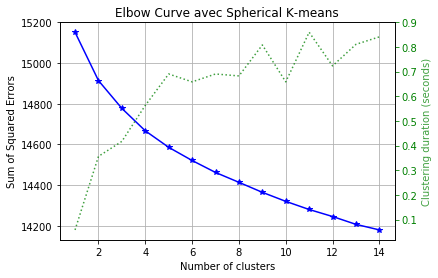

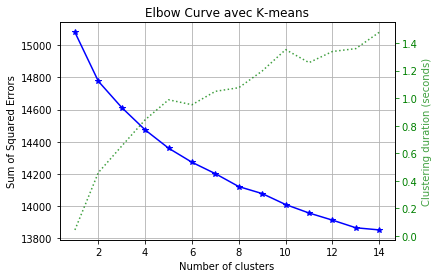

In [42]:
# Matrice embeddings de taille 150
analyse(methode=None,preproc=classic_embeddings_150,true_label=encoded_label_classic,nb_clusters=3,scikit=False,normalizer=False)

Results from Spherical K-means
ARI: 20.7052 NMI: 18.6522 Accuracy: 61.7579
Results from K-means
ARI: 11.2341 NMI: 19.8395 Accuracy: 50.4755


(None,
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[-0.07050487, -0.04838995, -0.00188498, ...,  0.21725591,
         -0.15439166,  0.02298876],
        [-0.28782779, -0.13114221, -0.06174774, ...,  0.02087453,
          0.28335607,  0.14468873],
        [-0.40352881,  0.29081556,  0.04631559, ..., -0.38752815,
         -0.05387403, -0.16680412],
        ...,
        [-0.05860046, -0.03836114, -0.16371503, ..., -0.00445048,
          0.02746398, -0.19151795],
        [-0.22364745, -0.00782468,  0.01318661, ...,  0.36891615,
          0.12865347,  0.33327156],
        [-0.09263396,  0.02351908,  0.00739881, ..., -0.10591555,
          0.0289875 , -0.1558359 ]]))

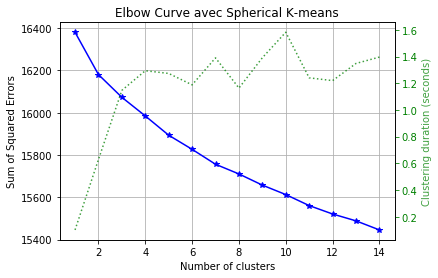

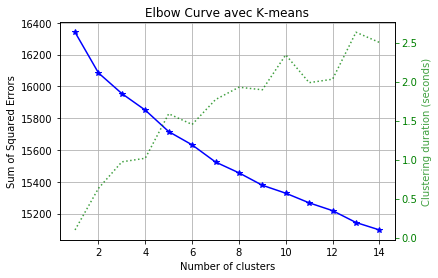

In [43]:
# Matrice embeddings de taille 200
analyse(methode=None,preproc=classic_embeddings_200,true_label=encoded_label_classic,nb_clusters=3,scikit=False,normalizer=False)

### Analyse Sur Classic3 en utilisant la LSA avec K-means et Sperical K-means 

In [44]:
lsa = TruncatedSVD(20, random_state=42,n_iter = 20)

Results from Spherical K-means
ARI: 93.093 NMI: 88.5893 Accuracy: 97.6356
Results from K-means
ARI: 13.0112 NMI: 29.1462 Accuracy: 51.632


(TruncatedSVD(algorithm='randomized', n_components=20, n_iter=20,
        random_state=42, tol=0.0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[ 5.94305214e-02,  4.26863425e-01, -1.42079092e-01, ...,
          2.12774103e-02, -1.42138073e-03,  1.19703945e-02],
        [ 2.67097502e+00,  6.59546747e-01,  2.41639632e+00, ...,
          1.34218076e+00,  3.18978787e-01,  3.16569153e-01],
        [ 1.09156604e+00,  1.07182712e+00, -2.68354921e-01, ...,
         -3.43066967e-01,  6.61617240e-01, -7.85027597e-01],
        ...,
        [ 2.65720501e-01,  3.53840986e-01, -6.18211848e-02, ...,
          1.87799473e-02,  7.15821272e-02, -4.31770684e-02],
        [ 8.44720354e+

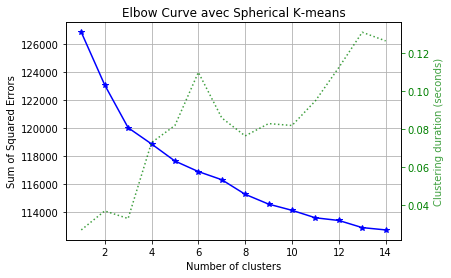

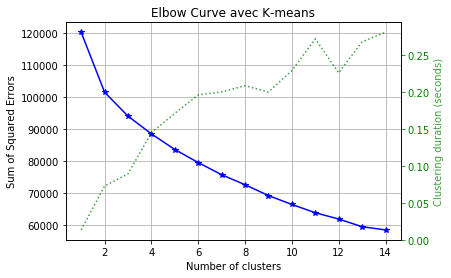

In [45]:
analyse(lsa,X_countVectorizer_Classic3,encoded_label_classic,normalizer=False)

Results from Spherical K-means
ARI: 93.093 NMI: 88.5893 Accuracy: 97.6356
Results from K-means
ARI: 92.5323 NMI: 87.834 Accuracy: 97.43


(TruncatedSVD(algorithm='randomized', n_components=20, n_iter=20,
        random_state=42, tol=0.0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[ 0.06666785,  0.478846  , -0.1593812 , ...,  0.02386853,
         -0.00159447,  0.01342813],
        [ 0.48462701,  0.11966947,  0.43843575, ...,  0.24352794,
          0.05787614,  0.05743894],
        [ 0.40761626,  0.40024529, -0.10021   , ..., -0.12810922,
          0.24706334, -0.29314765],
        ...,
        [ 0.33020341,  0.43970826, -0.07682345, ...,  0.02333731,
          0.0889531 , -0.05365493],
        [ 0.50830177,  0.04282956,  0.53423564, ...,  0.0867482 ,
          0.03328301, -0.06688363],
        [ 0.1745

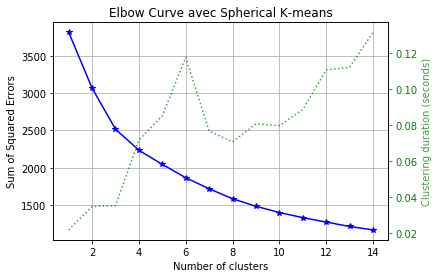

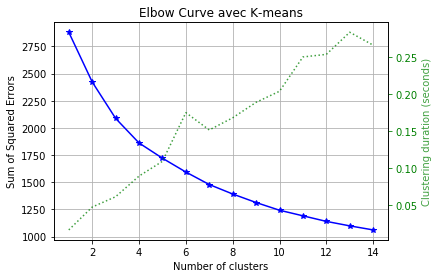

In [46]:
analyse(lsa,X_countVectorizer_Classic3,encoded_label_classic)

Results from Spherical K-means
ARI: 96.7545 NMI: 94.0433 Accuracy: 98.9206
Results from K-means
ARI: 58.7875 NMI: 65.0256 Accuracy: 82.7037


(TruncatedSVD(algorithm='randomized', n_components=20, n_iter=20,
        random_state=42, tol=0.0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[ 1.75325142e-02,  4.91841685e-02,  8.79197282e-03, ...,
          3.49864096e-03,  1.72153682e-04, -1.71496371e-03],
        [ 1.45734109e-01, -2.29096613e-02, -1.76668444e-01, ...,
          1.98455247e-02,  6.59020148e-03, -5.90644323e-02],
        [ 6.98601982e-02,  3.56296434e-02, -8.58108413e-03, ...,
         -1.03402532e-02,  2.75465089e-02, -8.62454527e-03],
        ...,
        [ 2.14795226e-02,  1.84635136e-02, -7.51962437e-03, ...,
          2.71578378e-04, -5.63042053e-03,  3.63805346e-03],
        [ 2.24683025e-

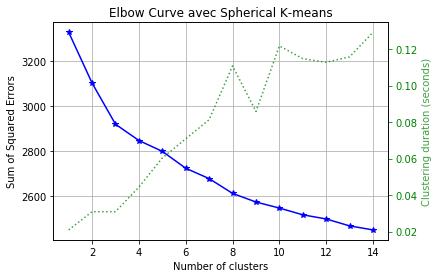

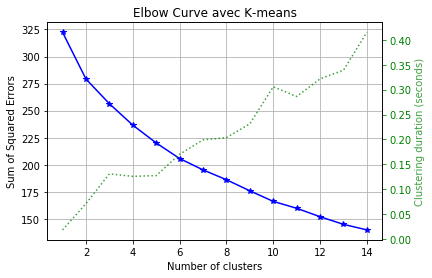

In [47]:
analyse(lsa,X_tfidf_Classic3,encoded_label_classic,normalizer=False)

Results from Spherical K-means
ARI: 96.7545 NMI: 94.0433 Accuracy: 98.9206
Results from K-means
ARI: 96.6124 NMI: 93.8117 Accuracy: 98.8692


(TruncatedSVD(algorithm='randomized', n_components=20, n_iter=20,
        random_state=42, tol=0.0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[ 0.19309006,  0.54167781,  0.09682824, ...,  0.03853143,
          0.00189597, -0.01888733],
        [ 0.44735613, -0.07032518, -0.54231444, ...,  0.06091928,
          0.02022977, -0.18130852],
        [ 0.45623951,  0.2326883 , -0.05604092, ..., -0.06752961,
          0.17989937, -0.05632475],
        ...,
        [ 0.30955326,  0.26608789, -0.10836946, ...,  0.00391387,
         -0.0811431 ,  0.05243   ],
        [ 0.38353669, -0.09144292, -0.39761402, ...,  0.00189993,
         -0.1348901 ,  0.16703119],
        [ 0.1747

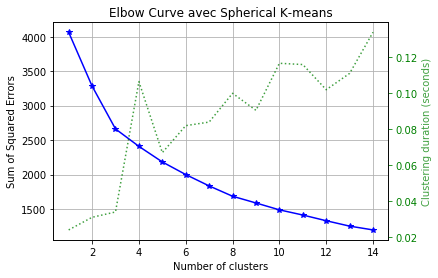

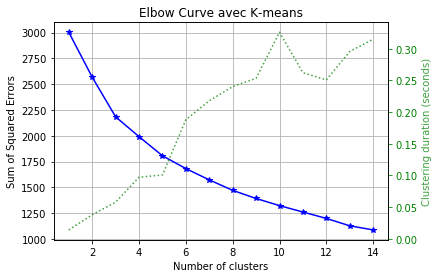

In [48]:
analyse(lsa,X_tfidf_Classic3,encoded_label_classic,normalizer=True)

### NMF avec Classic3

In [49]:
#initialization (better for sparseness)
# ‘nndsvd’: Nonnegative Double Singular Value Decomposition (NNDSVD)
model = NMF(n_components=20,init='nndsvd',max_iter=1000,random_state=42)

Results from Spherical K-means
ARI: 96.7072 NMI: 93.9083 Accuracy: 98.8949
Results from K-means
ARI: 93.1363 NMI: 88.8576 Accuracy: 97.6099


(NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
   max_iter=1000, n_components=20, random_state=42, shuffle=False,
   solver='cd', tol=0.0001, verbose=0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.11228475, ..., 0.        , 0.        ,
         0.        ],
        [0.00070229, 0.00265446, 0.        , ..., 0.        , 0.00327446,
         0.0073607 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.00255727,
         0.        ],
        [0.        , 0.00595191, 0.03810125, ..., 0.        , 0.0085

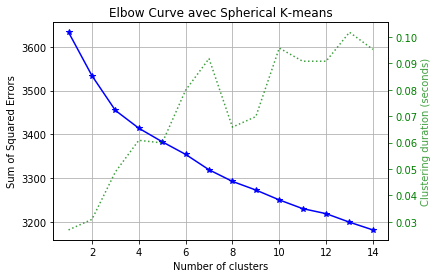

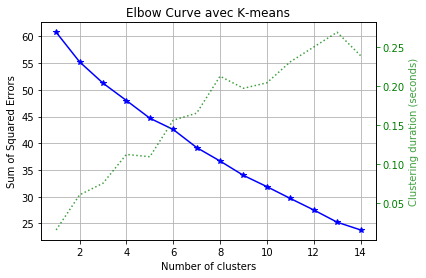

In [50]:
analyse(model,X_tfidf_Classic3,encoded_label_classic,normalizer=False)

Results from Spherical K-means
ARI: 96.7072 NMI: 93.9083 Accuracy: 98.8949
Results from K-means
ARI: 96.5417 NMI: 93.6446 Accuracy: 98.8435


(NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
   max_iter=1000, n_components=20, random_state=42, shuffle=False,
   solver='cd', tol=0.0001, verbose=0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.89947315, ..., 0.        , 0.        ,
         0.        ],
        [0.01323727, 0.05003333, 0.        , ..., 0.        , 0.06171947,
         0.13873995],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.08887106,
         0.        ],
        [0.        , 0.01921394, 0.12299835, ..., 0.        , 0.0275

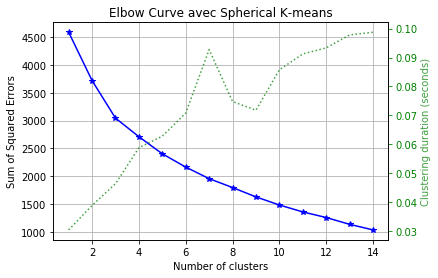

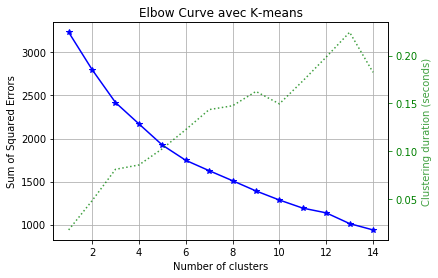

In [51]:
analyse(model,X_tfidf_Classic3,encoded_label_classic)

Results from Spherical K-means
ARI: 90.2329 NMI: 84.701 Accuracy: 96.659
Results from K-means
ARI: 89.2741 NMI: 83.6773 Accuracy: 96.3249


(NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
   max_iter=1000, n_components=20, random_state=42, shuffle=False,
   solver='cd', tol=0.0001, verbose=0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.30976931, 0.        , 0.        , ..., 0.77014882, 0.        ,
         0.        ],
        [0.        , 0.06207565, 0.        , ..., 0.0711612 , 0.        ,
         0.        ],
        ...,
        [0.        , 0.09609953, 0.01457259, ..., 0.        , 0.        ,
         0.        ],
        [0.00791363, 0.04391034, 0.        , ..., 0.23587971, 0.    

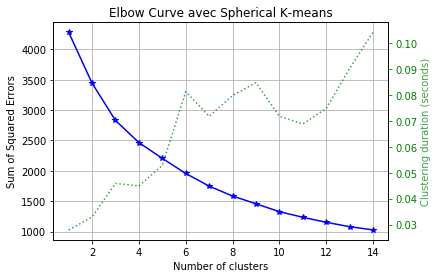

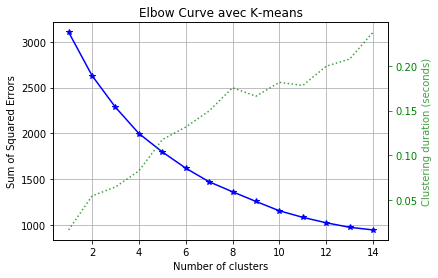

In [52]:
analyse(model,X_countVectorizer_Classic3,encoded_label_classic)

Results from Spherical K-means
ARI: 90.2329 NMI: 84.701 Accuracy: 96.659
Results from K-means
ARI: 10.7404 NMI: 26.4503 Accuracy: 50.0129


(NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
   max_iter=1000, n_components=20, random_state=42, shuffle=False,
   solver='cd', tol=0.0001, verbose=0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.15121488, 0.        , 0.        , ..., 0.3759506 , 0.        ,
         0.        ],
        [0.        , 0.01203415, 0.        , ..., 0.0137955 , 0.        ,
         0.        ],
        ...,
        [0.        , 0.0062741 , 0.00095141, ..., 0.        , 0.        ,
         0.        ],
        [0.01177936, 0.0653601 , 0.        , ..., 0.35110456, 0.    

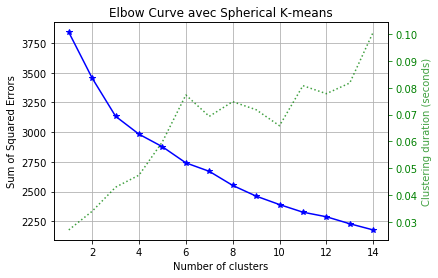

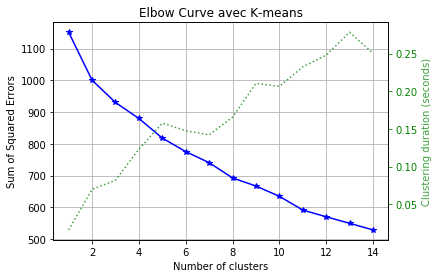

In [53]:
analyse(model,X_countVectorizer_Classic3,encoded_label_classic,normalizer=False)

#### DOC2VEC avec Classic3

In [373]:
tagged_data = [TaggedDocument(words=word_tokenize(i.lower()), tags=[str(_d)]) for i, _d in zip(classic_raw.values.ravel(),encoded_label_classic)]

In [374]:
len(vectorizer.get_feature_names())

19758

In [375]:
max_epochs = 100
alpha = 0.025

model = Doc2Vec(alpha=alpha,
                vector_size = 20,
                min_alpha=0.00025,
                min_count=1,
                dm=1,
                epoch=max_epochs,
                workers=multiprocessing.cpu_count())
  
model.build_vocab([x for x in tqdm_notebook(tagged_data)])

for epoch in tqdm_notebook(range(max_epochs)):
    model.train(tagged_data,
                total_examples=model.corpus_count,epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  app.launch_new_instance()


Model Saved


In [376]:
tagged_data = pd.DataFrame(TaggedDocument(words=word_tokenize(i.lower()), tags=[str(_d)]) for i, _d in zip(classic_raw.values.ravel(),encoded_label_classic))

In [377]:
y_train, X_train = vec_for_learning(model, tagged_data)

Results from Spherical K-means
ARI: 98.8073 NMI: 97.8145 Accuracy: 99.6145
Results from K-means
ARI: 98.8073 NMI: 97.8145 Accuracy: 99.6145


(<gensim.models.doc2vec.Doc2Vec at 0x1de19086e48>,
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances=True,
     random_state=42, tol=0.0001, verbose=0),
 array([[ 0.07484543,  0.09309547,  0.28212878, ...,  0.06086526,
         -0.11702613, -0.21794917],
        [-0.09566353,  0.15198337,  0.34196922, ...,  0.04966461,
         -0.22037478, -0.29086116],
        [ 0.05652868,  0.06124553,  0.22932692, ..., -0.2795541 ,
         -0.02615048, -0.20376198],
        ...,
        [-0.10130747,  0.05092734,  0.43780428, ..., -0.20557918,
         -0.10903605, -0.12245616],
        [ 0.11811849,  0.24844505,  0.19140255, ...,  0.0219193 ,
         -0.2376215 , -0.35107237],
        [-0.11397404,  0.12702778,  0.44077697, ..., -0.06796066,
  

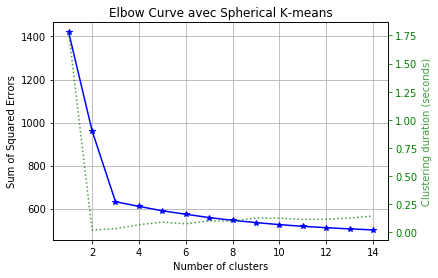

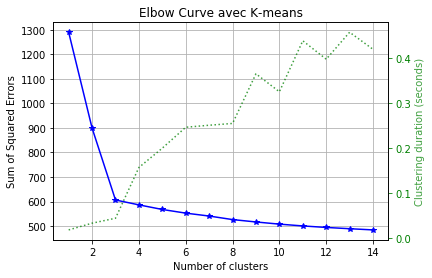

In [378]:
analyse(model,X_train,encoded_label_classic,normalizer=True,scikit=False)

Results from Spherical K-means
ARI: 98.8073 NMI: 97.8145 Accuracy: 99.6145
Results from K-means
ARI: 99.0351 NMI: 98.1944 Accuracy: 99.6916


(<gensim.models.doc2vec.Doc2Vec at 0x1de19086e48>,
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=3, n_init=10, n_jobs=-1, precompute_distances=True,
     random_state=42, tol=0.0001, verbose=0),
 (array([ 0.2682732 ,  0.333688  ,  1.011252  , -0.8184078 , -0.19703504,
         -2.0495055 , -0.01204168,  0.8492595 ,  0.18742795, -0.19720154,
         -0.5344809 , -0.2510746 , -0.6253574 ,  0.34592006,  1.8277406 ,
         -0.06923284,  0.9479018 ,  0.21816322, -0.41946417, -0.78120905],
        dtype=float32),
  array([-0.5976481 ,  0.9495004 ,  2.1364174 , -1.6983519 , -0.913599  ,
         -2.5207691 , -0.8898991 ,  1.5955225 , -0.5256173 , -0.10502707,
          1.1189395 , -1.7051221 , -0.07235085,  1.3622723 ,  2.2402062 ,
         -0.6918809 ,  1.6423405 ,  0.3102745 , 

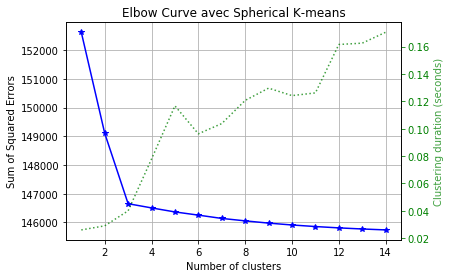

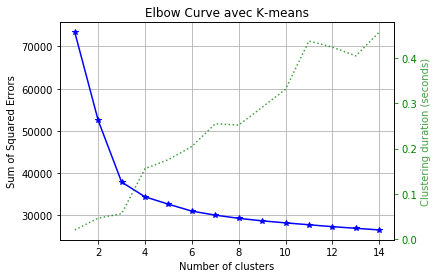

In [379]:
analyse(model,X_train,encoded_label_classic,normalizer=False,scikit=False)

#### Analyse sur Reurs8-Embeddings avec Kmeans et Skmeans

In [ ]:
analyse(methode=None,preproc=reuters_embeddings,true_label=encoded_label_reuers,nb_clusters=8,scikit=False,normalizer=True)

In [ ]:
analyse(methode=None,preproc=reuters_embeddings,true_label=encoded_label_reuers,nb_clusters=8,scikit=False,normalizer=False)

### Analyse Sur Reuers8 en utilisant la LSA avec K-means et Sperical K-means 

In [67]:
lsa_reuers = TruncatedSVD(20,random_state=42)

Results from Spherical K-means
ARI: 32.9441 NMI: 44.5163 Accuracy: 49.1158
Results from K-means
ARI: 20.0099 NMI: 38.4592 Accuracy: 33.546


(TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
        random_state=42, tol=0.0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[ 0.3242349 ,  0.33744044,  0.15783833, ..., -0.17208451,
          0.08744427,  0.12103888],
        [ 0.34259433,  0.61284113, -0.22831599, ..., -0.01452402,
          0.09672774,  0.14079611],
        [ 0.94312128, -0.10307209,  0.21974198, ..., -0.01038628,
         -0.07699081, -0.03681852],
        ...,
        [ 0.10652838,  0.2494776 , -0.1935567 , ..., -0.15868975,
          0.27692792,  0.20357856],
        [ 0.15636136,  0.47435614, -0.26178709, ...,  0.06714159,
         -0.04941826, -0.08654338],
        [ 0.13256

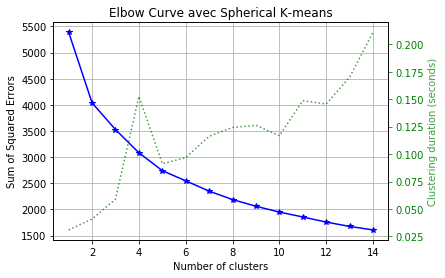

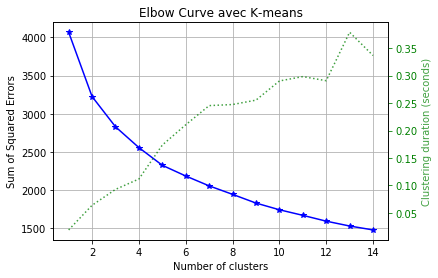

In [68]:
analyse(lsa_reuers,X_countVectorizer_Reuers8,encoded_label_reuers,nb_clusters=8,normalizer=True)

Results from Spherical K-means
ARI: 32.9441 NMI: 44.5163 Accuracy: 49.1158
Results from K-means
ARI: 2.2288 NMI: 26.6602 Accuracy: 37.3747


(TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
        random_state=42, tol=0.0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[ 1.50807401,  1.56949534,  0.73413408, ..., -0.80039559,
          0.4067188 ,  0.56297328],
        [ 2.84951231,  5.09727742, -1.89900758, ..., -0.12080286,
          0.80452845,  1.17106505],
        [ 8.5160957 , -0.93070931,  1.98420262, ..., -0.0937849 ,
         -0.6952034 , -0.33245991],
        ...,
        [ 0.34513835,  0.80827555, -0.62709899, ..., -0.51413452,
          0.8972111 ,  0.65956852],
        [ 0.37973999,  1.15202374, -0.63577746, ...,  0.1630604 ,
         -0.12001743, -0.2101797 ],
        [ 0.47369

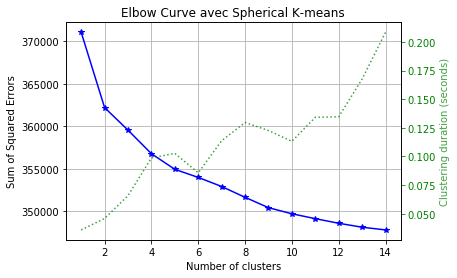

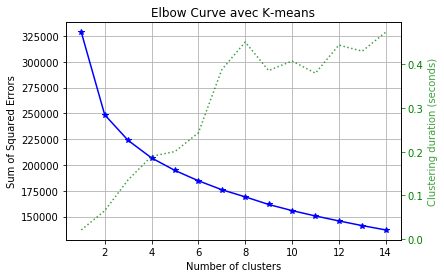

In [69]:
analyse(lsa_reuers,X_countVectorizer_Reuers8,encoded_label_reuers,nb_clusters=8,normalizer=False)

Results from Spherical K-means
ARI: 28.6394 NMI: 51.421 Accuracy: 39.0702
Results from K-means
ARI: -2.3276 NMI: 28.5004 Accuracy: 42.2607


(TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
        random_state=42, tol=0.0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[ 6.14881219e-02,  1.32350018e-01, -7.63226878e-02, ...,
         -7.03864451e-02,  1.29654800e-01,  3.21578153e-02],
        [ 3.83665459e-02,  2.15632606e-02, -7.00008867e-02, ...,
         -6.60361172e-02, -2.41978958e-03,  5.56339688e-02],
        [ 5.79517403e-01, -7.02929628e-03, -2.57461507e-01, ...,
          4.29379536e-05, -7.45044384e-04,  2.95083079e-02],
        ...,
        [ 2.89332390e-02,  2.13100927e-01,  2.76152847e-02, ...,
          4.27120443e-02, -1.12634203e-01, -1.92176031e-02],
        [ 1.13041884e-0

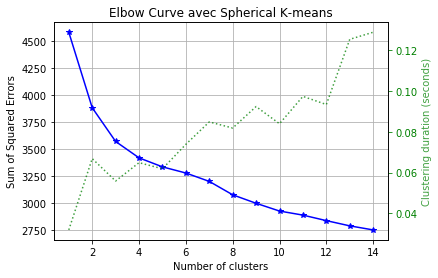

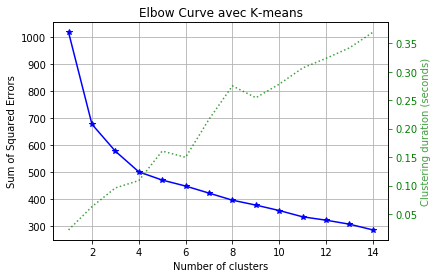

In [70]:
analyse(lsa_reuers,X_tfidf_Reuers8,encoded_label_reuers,nb_clusters=8,normalizer=False)

Results from Spherical K-means
ARI: 28.6394 NMI: 51.421 Accuracy: 39.0702
Results from K-means
ARI: 39.986 NMI: 53.8431 Accuracy: 53.5825


(TruncatedSVD(algorithm='randomized', n_components=20, n_iter=5,
        random_state=42, tol=0.0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[ 1.20593985e-01,  2.59572347e-01, -1.49688375e-01, ...,
         -1.38045880e-01,  2.54286333e-01,  6.30697277e-02],
        [ 1.48545051e-01,  8.34872040e-02, -2.71024796e-01, ...,
         -2.55674265e-01, -9.36878102e-03,  2.15399916e-01],
        [ 8.65598809e-01, -1.04993404e-02, -3.84558552e-01, ...,
          6.41344700e-05, -1.11283894e-03,  4.40752186e-02],
        ...,
        [ 7.57226376e-02,  5.57717172e-01,  7.22733531e-02, ...,
          1.11783843e-01, -2.94780647e-01, -5.02953574e-02],
        [ 7.08256895e-0

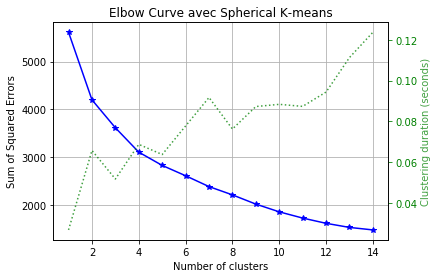

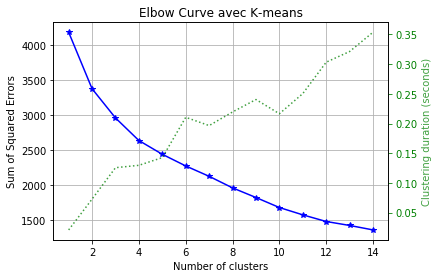

In [71]:
analyse(lsa_reuers,X_tfidf_Reuers8,encoded_label_reuers,nb_clusters=8,normalizer=True)

### NMF sur Reuers8

In [62]:
model = NMF(n_components=20, init='nndsvd',max_iter=1000,random_state=42)

Results from Spherical K-means
ARI: 34.9704 NMI: 47.1963 Accuracy: 50.1003
Results from K-means
ARI: 19.7722 NMI: 41.3803 Accuracy: 33.619


(NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
   max_iter=1000, n_components=20, random_state=42, shuffle=False,
   solver='cd', tol=0.0001, verbose=0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.33799307, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.81426772, 0.20671707, 0.21891695, ..., 0.        , 0.00220791,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00342437, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.42151471, 0.    

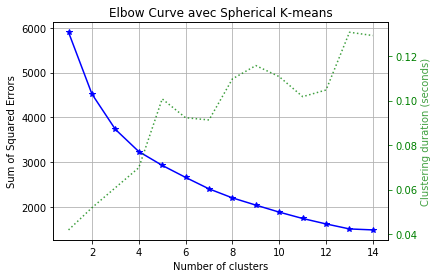

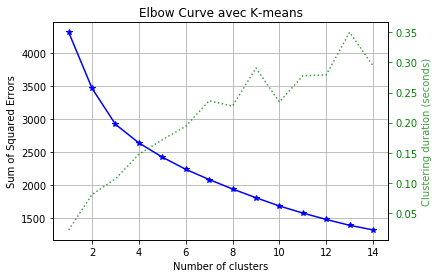

In [63]:
analyse(model,X_countVectorizer_Reuers8,encoded_label_reuers,nb_clusters=8,normalizer=True)

Results from Spherical K-means
ARI: 34.9704 NMI: 47.1963 Accuracy: 50.1003
Results from K-means
ARI: 2.3113 NMI: 26.2335 Accuracy: 43.5916


(NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
   max_iter=1000, n_components=20, random_state=42, shuffle=False,
   solver='cd', tol=0.0001, verbose=0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.19401347, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.37214364, 0.09447561, 0.10005131, ..., 0.        , 0.00100908,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.00106902, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.07006873, 0.    

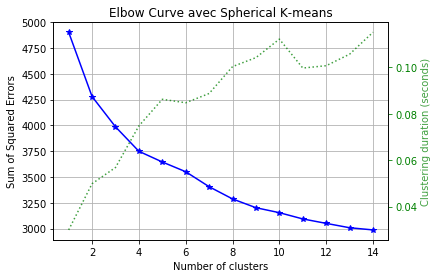

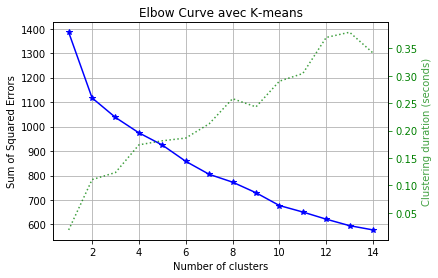

In [64]:
analyse(model,X_countVectorizer_Reuers8,encoded_label_reuers,nb_clusters=8,normalizer=False)

Results from Spherical K-means
ARI: 23.9584 NMI: 44.6296 Accuracy: 41.9143
Results from K-means
ARI: 22.6155 NMI: 43.6898 Accuracy: 41.1304


(NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
   max_iter=1000, n_components=20, random_state=42, shuffle=False,
   solver='cd', tol=0.0001, verbose=0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[0.        , 0.01640156, 0.        , ..., 0.00300441, 0.97672221,
         0.05735279],
        [0.        , 0.        , 0.        , ..., 0.0299629 , 0.2654387 ,
         0.01755809],
        [0.65515161, 0.        , 0.02013374, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.08446193, 0.        , ..., 0.        , 0.18092744,
         0.02142937],
        [0.        , 0.        , 0.00186663, ..., 0.        , 0.    

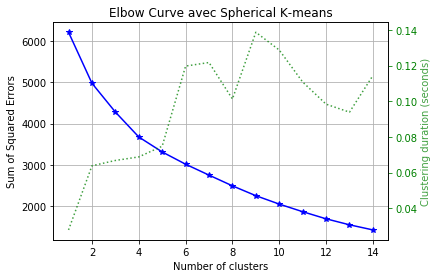

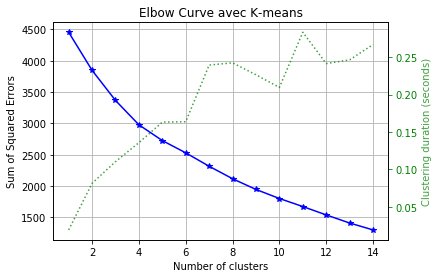

In [65]:
analyse(model,X_tfidf_Reuers8,encoded_label_reuers,nb_clusters=8,normalizer=True)

Results from Spherical K-means
ARI: 23.9584 NMI: 44.6296 Accuracy: 41.9143
Results from K-means
ARI: 15.5206 NMI: 39.999 Accuracy: 49.1705


(NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
   max_iter=1000, n_components=20, random_state=42, shuffle=False,
   solver='cd', tol=0.0001, verbose=0),
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
     random_state=42, tol=0.0001, verbose=0),
 array([[0.00000000e+00, 3.15910436e-03, 0.00000000e+00, ...,
         5.78679614e-04, 1.88126460e-01, 1.10467205e-02],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.64768920e-03, 2.34556500e-02, 1.55153136e-03],
        [6.73964664e-02, 0.00000000e+00, 2.07118951e-03, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 8.26340013e-03, 0.00000000e+00, ...,
         0.00000000e+00, 1.770

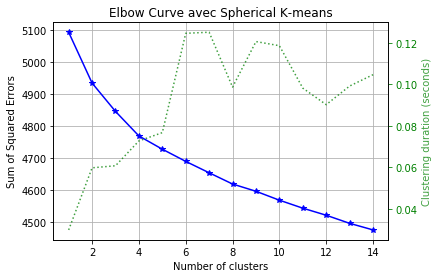

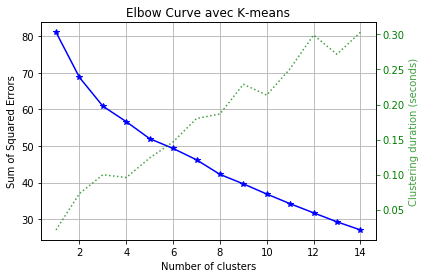

In [66]:
analyse(model,X_tfidf_Reuers8,encoded_label_reuers,nb_clusters=8,normalizer=False)

### DOC2VEC

In [366]:
tagged_data = [TaggedDocument(words=word_tokenize(i.lower()), tags=[str(_d)]) for i, _d in zip(reuters_raw.values.ravel(),encoded_label_reuers)]

In [367]:
len(vectorizer.get_feature_names())

19758

In [368]:
max_epochs = 100
alpha = 0.025

model = Doc2Vec(alpha=alpha,
                vector_size = 20,
                min_alpha=0.00025,
                min_count=1,
                dm=0,
                workers=multiprocessing.cpu_count())
  
model.build_vocab([x for x in tqdm_notebook(tagged_data)])

for epoch in tqdm_notebook(range(max_epochs)):
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  app.launch_new_instance()


Model Saved


In [369]:
tagged_data = pd.DataFrame(TaggedDocument(words=word_tokenize(i.lower()), tags=[str(_d)]) for i, _d in zip(reuters_raw.values.ravel(),encoded_label_reuers))

In [370]:
y_train, X_train = vec_for_learning(model, tagged_data)

Results from Spherical K-means
ARI: 55.5239 NMI: 75.6705 Accuracy: 61.1668
Results from K-means
ARI: 80.4282 NMI: 78.2405 Accuracy: 76.7366


(<gensim.models.doc2vec.Doc2Vec at 0x1dc9bfbef60>,
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=-1, precompute_distances=True,
     random_state=42, tol=0.0001, verbose=0),
 array([[-0.10939678,  0.11960427,  0.46707183, ..., -0.29125625,
         -0.25574252,  0.23850918],
        [-0.37256414, -0.09819528,  0.3428593 , ...,  0.08669937,
          0.09723105,  0.13039255],
        [ 0.17331168,  0.06375141,  0.2377483 , ..., -0.63124394,
         -0.26095444,  0.01075935],
        ...,
        [ 0.00113434, -0.09205315,  0.19054633, ..., -0.5161182 ,
         -0.17949383,  0.24907395],
        [-0.01504552, -0.15604533,  0.20236202, ..., -0.18983065,
         -0.22274216, -0.33701766],
        [ 0.08273632, -0.07177573,  0.07710089, ..., -0.10811766,
  

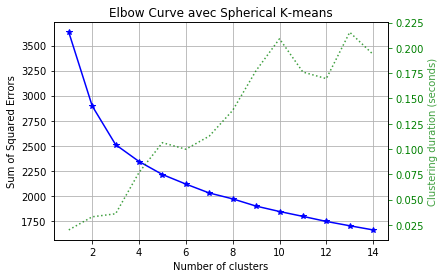

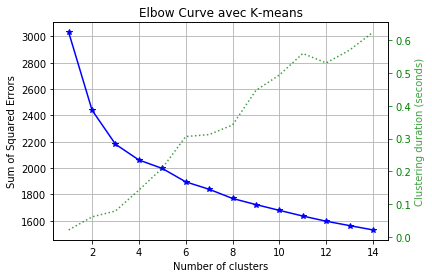

In [371]:
analyse(model,X_train,encoded_label_reuers,nb_clusters=8,normalizer=True,scikit=False)

Results from Spherical K-means
ARI: 55.5239 NMI: 75.6705 Accuracy: 61.1668
Results from K-means
ARI: 56.1689 NMI: 74.955 Accuracy: 62.4977


(<gensim.models.doc2vec.Doc2Vec at 0x1dc9bfbef60>,
 SphericalKMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8,
         n_init=10, n_jobs=-1, normalize=True, random_state=42, tol=0.0001,
         verbose=0),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
     n_clusters=8, n_init=10, n_jobs=-1, precompute_distances=True,
     random_state=42, tol=0.0001, verbose=0),
 (array([-0.32375565,  0.35396436,  1.3822815 ,  0.35487667,  0.27689216,
          0.09309858,  0.56286854, -0.22162026, -0.1345738 ,  0.18596366,
         -0.7699614 ,  0.6673697 , -1.0589402 , -0.3125224 ,  1.1066077 ,
         -0.46550575, -0.68929404, -0.8619619 , -0.7568604 ,  0.70585895],
        dtype=float32),
  array([-1.3664175 , -0.36014137,  1.2574719 ,  0.07700076,  0.39503047,
         -1.8660543 ,  0.8018051 ,  0.6309944 , -0.6100465 , -0.02654566,
         -1.3996184 ,  0.6436096 , -0.98829776, -0.46120727,  0.61055785,
          0.2531562 ,  0.5989821 ,  0.31797892, 

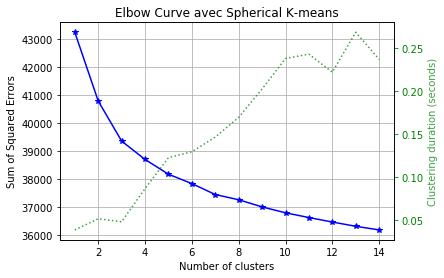

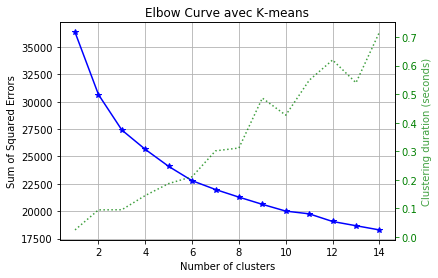

In [372]:
analyse(model,X_train,encoded_label_reuers,nb_clusters=8,normalizer=False,scikit=False)